# Imports / Data Preparation

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import tarfile
import random
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [ ]:
# To safely store your training progress, use Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.device('/GPU:0')

In [ ]:
batch_size = 32
img_height = 32
img_width = 32

In [ ]:
dataset_path = '/content/drive/MyDrive/comp4211_project/flying_objects'
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8784 files belonging to 5 classes.
Using 7028 files for training.
Found 8784 files belonging to 5 classes.
Using 1756 files for validation.


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to datasets
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

for images, labels in train_ds.take(1):
    print(f"Training batch shape: {images.shape}, Labels shape: {labels.shape}")

for images, labels in val_ds.take(1):
    print(f"Validation batch shape: {images.shape}, Labels shape: {labels.shape}")

Training batch shape: (32, 32, 32, 3), Labels shape: (32,)
Validation batch shape: (32, 32, 32, 3), Labels shape: (32,)


# Important constants

In [ ]:
image_labels = ['bird', 'drone', 'fighter_jet', 'helicopter', 'missile']
n_class = len(image_labels)  # Number of classes
num_classes = 5

# Data visualization

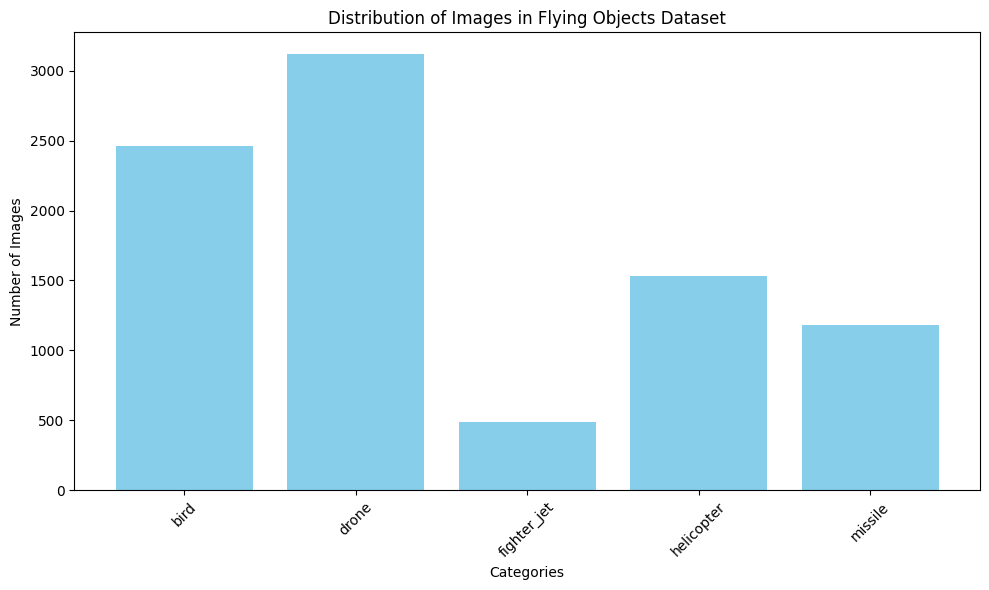

In [ ]:
import os
image_counts = []

# Count the number of images in each category
for label in image_labels:
    category_path = os.path.join(dataset_path, label)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        image_counts.append(len(images))
    else:
        image_counts.append(0)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(image_labels, image_counts, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Flying Objects Dataset')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the bar chart
plt.show()

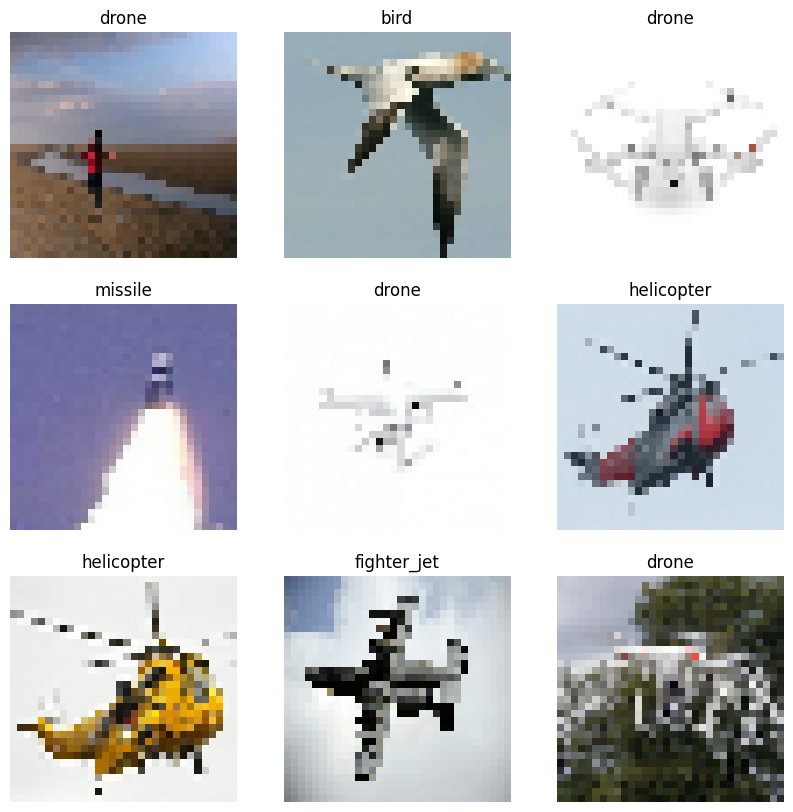

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # Take one batch from the dataset
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)

        # Directly visualize the normalized image (in the range [0, 1])
        plt.imshow(images[i])  # No need to convert to uint8 or rescale

        # Set the title using the corresponding label
        plt.title(image_labels[int(labels[i])])  # Ensure labels are accessed correctly
        plt.axis("off")  # Turn off axis

plt.show()

# Classification

# Model Setting

In [ ]:
# --- start of code referring from PA2
# model definition

from tensorflow.keras.layers import Conv2D, LeakyReLU, Add, BatchNormalization

class ResBlock(tf.keras.Model):
    def __init__(self, in_channels: int, out_channels: int, downsampling=False):
        super(ResBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.downsampling = downsampling

        self.activation1 = LeakyReLU()
        self.conv1 = Conv2D(out_channels, kernel_size=(3, 3), padding='same', use_bias=False)


        self.activation2 = LeakyReLU()
        self.conv2 = Conv2D(out_channels, kernel_size=(3, 3), padding='same', strides=(2 if downsampling else 1), use_bias=False)

        if downsampling or in_channels != out_channels:
            self.skip_conv = Conv2D(out_channels, kernel_size=(1, 1), strides=(2 if downsampling else 1), use_bias=False)
        else:
            self.skip_conv = None

    def call(self, x):
        residual = x
        x = self.activation1(self.conv1(x))  #
        x = self.activation2(self.conv2(x))

        if self.skip_conv:
            residual = self.skip_conv(residual)

        return Add()([x, residual])

    def get_config(self):
        config = super().get_config()
        config.update({
            'in_channels': self.in_channels,
            'out_channels': self.out_channels,
            'downsampling': self.downsampling,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

class WRN(tf.keras.Model):
    def __init__(self, num_classes: int = 5):
        super(WRN, self).__init__()

        self.model = tf.keras.Sequential([
            Conv2D(16, kernel_size=(3, 3), strides=1, padding='same', input_shape=(None, None, 3), use_bias=False),
            ResBlock(16, 64, False),
            ResBlock(64, 64, False),
            ResBlock(64, 128, True),
            ResBlock(128, 128, False),
            ResBlock(128, 256, True),
            ResBlock(256, 256, False),
            BatchNormalization(),
            LeakyReLU(),
            Dropout(0.5),  # Adding dropout for regularization
            GlobalAveragePooling2D(),
            Dense(units=num_classes)
        ])

    def call(self, x):
        return self.model(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            'num_classes': self.model.layers[-1].units,
            'model': [tf.keras.layers.serialize(layer) for layer in self.model.layers],
        })
        return config

    @classmethod
    def from_config(cls, config):
        model_layers = [tf.keras.layers.deserialize(layer) for layer in config.pop('model')]

        instance = cls(num_classes=config.pop('num_classes'))

        for layer in model_layers:
            instance.add(layer)

        return instance



# Model Summary of Model

In [ ]:
wrn_model = WRN(num_classes=5)
wrn_model.build((None, 32, 32, 3))
wrn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "wrn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 5)                   │       2,745,013 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,745,013 (10.47 MB)

 Trainable params: 2,744,501 (10.47 MB)

 Non-trainable params: 512 (2.00 KB)

# Training

In [ ]:
# Training Step
def training_step(optim: optimizers.Optimizer, model: tf.keras.Model, data: tf.Tensor, label: tf.Tensor, sigma: float = 0.03) -> dict:
    # Step 1: Preprocessing
    x, y = data, label

    # Convert labels to one-hot encoding
    y_one_hot = tf.one_hot(y, depth=num_classes)  # Assuming y is a tensor of class indices

    # Augment the image data by adding Gaussian noise
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=sigma, dtype=tf.float32)
    x_augmented = x + noise

    # Step 2: Train model
    with tf.GradientTape() as g:
        # Step 2a: Calculate logits for the image batch
        logits = model(x_augmented, training=True)  # Set training=True to enable dropout, batch normalization, etc.

        # Step 2b: Compute categorical cross-entropy loss
        loss = tf.keras.losses.categorical_crossentropy(y_one_hot, logits, from_logits=True)
        total_loss = tf.reduce_mean(loss)  # Average loss over the batch

    # Step 3: Obtain the gradients and apply them (using optimizer)
    gradients = g.gradient(total_loss, model.trainable_variables)
    optim.apply_gradients(zip(gradients, model.trainable_variables))

    # Step 4: Return loss (or other values if needed)
    return {
        "loss": total_loss
    }

In [ ]:
# Accuracy Calculation
def evaluate_accuracy(model, dataset):
    correct_predictions = 0
    total_predictions = 0

    # Iterate through the dataset
    for batch_x, batch_y in dataset:
        # Make predictions
        logits = model(batch_x, training=False)  # Set training=False to disable dropout, etc.

        # Get the predicted class indices
        predicted_classes = tf.argmax(logits, axis=1, output_type=tf.int32)  # Ensure output is int32

        # Count correct predictions
        correct_predictions += tf.reduce_sum(tf.cast(tf.equal(predicted_classes, tf.cast(batch_y, tf.int32)), tf.int32)).numpy()
        total_predictions += batch_y.shape[0]  # Number of samples in the batch

    # Calculate accuracy
    accuracy = correct_predictions / total_predictions
    return accuracy

In [ ]:
# Training
def training_loop(model, optimizer, train_step, epochs: int = 20, save_interval: int = 5, sigma: float = 0.03):
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        num_batches = 0

        # Wrap the training dataset with tqdm to create a progress bar
        with tqdm(train_ds, unit="batch") as tepoch:
            for step, (batch_x, batch_y) in enumerate(tepoch):
                # Execute a train step and get the losses
                loss_dict = train_step(optimizer, model, batch_x, batch_y, sigma = sigma)
                epoch_loss += loss_dict["loss"]

                # Accumulate number of batches (for average loss calculation)
                num_batches += 1

                # Update the progress bar description with the current loss
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(**loss_dict)

        # Evaluate accuracy on validation set at the end of each epoch
        test_accuracy = evaluate_accuracy(model, val_ds)
        print(f"Validation Accuracy: {test_accuracy * 100:.2f}%")

        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")

        if epoch % save_interval == 0:
            model.save_weights(f'model-{epoch}.weights.h5')
# --- end of code referring from PA2

# Hyperparameters Selection

In [ ]:
optimizer1 = optimizers.Adam(learning_rate=1e-4)

# Start training loop with train_ds and val_ds
testing_model1 = WRN(num_classes=5)
testing_model1.build((None, 32, 32, 3))
training_loop(testing_model1, optimizer1, training_step, epochs=10, sigma=0.01)

Epoch 1: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.9592185, shape=(), dtype=float32)]


Validation Accuracy: 49.72%
Epoch 1, Average Loss: 1.2915


Epoch 2: 100%|██████████| 220/220 [00:51<00:00,  4.29batch/s, loss=tf.Tensor(0.8424451, shape=(), dtype=float32)]


Validation Accuracy: 62.98%
Epoch 2, Average Loss: 1.0508


Epoch 3: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(1.026773, shape=(), dtype=float32)]


Validation Accuracy: 62.47%
Epoch 3, Average Loss: 0.9359


Epoch 4: 100%|██████████| 220/220 [00:51<00:00,  4.30batch/s, loss=tf.Tensor(0.6096586, shape=(), dtype=float32)]


Validation Accuracy: 64.81%
Epoch 4, Average Loss: 0.8760


Epoch 5: 100%|██████████| 220/220 [00:52<00:00,  4.23batch/s, loss=tf.Tensor(0.91529286, shape=(), dtype=float32)]


Validation Accuracy: 69.02%
Epoch 5, Average Loss: 0.8090


Epoch 6: 100%|██████████| 220/220 [00:51<00:00,  4.29batch/s, loss=tf.Tensor(0.67953503, shape=(), dtype=float32)]


Validation Accuracy: 73.92%
Epoch 6, Average Loss: 0.7477


Epoch 7: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(1.0337754, shape=(), dtype=float32)]


Validation Accuracy: 75.28%
Epoch 7, Average Loss: 0.7070


Epoch 8: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.86079323, shape=(), dtype=float32)]


Validation Accuracy: 74.94%
Epoch 8, Average Loss: 0.6578


Epoch 9: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.7307087, shape=(), dtype=float32)]


Validation Accuracy: 75.74%
Epoch 9, Average Loss: 0.6169


Epoch 10: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.5161484, shape=(), dtype=float32)]


Validation Accuracy: 77.05%
Epoch 10, Average Loss: 0.5800


In [ ]:
optimizer2 = optimizers.Adam(learning_rate=1e-4)

# Start training loop with train_ds and val_ds
testing_model2 = WRN(num_classes=5)
testing_model2.build((None, 32, 32, 3))
training_loop(testing_model2, optimizer2, training_step, epochs=10, sigma=0.03)

Epoch 1: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(1.4610975, shape=(), dtype=float32)]


Validation Accuracy: 52.79%
Epoch 1, Average Loss: 1.2861


Epoch 2: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.70206815, shape=(), dtype=float32)]


Validation Accuracy: 60.82%
Epoch 2, Average Loss: 1.0418


Epoch 3: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.5172896, shape=(), dtype=float32)]


Validation Accuracy: 66.23%
Epoch 3, Average Loss: 0.9273


Epoch 4: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.7034303, shape=(), dtype=float32)]


Validation Accuracy: 69.48%
Epoch 4, Average Loss: 0.8491


Epoch 5: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.7822832, shape=(), dtype=float32)]


Validation Accuracy: 69.36%
Epoch 5, Average Loss: 0.7806


Epoch 6: 100%|██████████| 220/220 [00:50<00:00,  4.32batch/s, loss=tf.Tensor(0.44736975, shape=(), dtype=float32)]


Validation Accuracy: 71.53%
Epoch 6, Average Loss: 0.7306


Epoch 7: 100%|██████████| 220/220 [00:52<00:00,  4.22batch/s, loss=tf.Tensor(0.7441064, shape=(), dtype=float32)]


Validation Accuracy: 73.12%
Epoch 7, Average Loss: 0.6674


Epoch 8: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.64195347, shape=(), dtype=float32)]


Validation Accuracy: 75.74%
Epoch 8, Average Loss: 0.6383


Epoch 9: 100%|██████████| 220/220 [00:52<00:00,  4.20batch/s, loss=tf.Tensor(0.925233, shape=(), dtype=float32)]


Validation Accuracy: 76.77%
Epoch 9, Average Loss: 0.5980


Epoch 10: 100%|██████████| 220/220 [00:51<00:00,  4.31batch/s, loss=tf.Tensor(0.5593081, shape=(), dtype=float32)]


Validation Accuracy: 76.88%
Epoch 10, Average Loss: 0.5572


In [ ]:
optimizer3 = optimizers.Adam(learning_rate=1e-4)

# Start training loop with train_ds and val_ds
testing_model3 = WRN(num_classes=5)
testing_model3.build((None, 32, 32, 3))
training_loop(testing_model3, optimizer3, training_step, epochs=10, sigma=0.05)

Epoch 1: 100%|██████████| 220/220 [00:52<00:00,  4.20batch/s, loss=tf.Tensor(1.1185634, shape=(), dtype=float32)]


Validation Accuracy: 53.30%
Epoch 1, Average Loss: 1.2618


Epoch 2: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.8997018, shape=(), dtype=float32)]


Validation Accuracy: 63.84%
Epoch 2, Average Loss: 1.0183


Epoch 3: 100%|██████████| 220/220 [00:53<00:00,  4.12batch/s, loss=tf.Tensor(0.6727982, shape=(), dtype=float32)]


Validation Accuracy: 67.14%
Epoch 3, Average Loss: 0.9154


Epoch 4: 100%|██████████| 220/220 [00:53<00:00,  4.14batch/s, loss=tf.Tensor(1.0251575, shape=(), dtype=float32)]


Validation Accuracy: 67.31%
Epoch 4, Average Loss: 0.8406


Epoch 5: 100%|██████████| 220/220 [00:52<00:00,  4.20batch/s, loss=tf.Tensor(0.48434177, shape=(), dtype=float32)]


Validation Accuracy: 70.05%
Epoch 5, Average Loss: 0.7763


Epoch 6: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.79275674, shape=(), dtype=float32)]


Validation Accuracy: 73.69%
Epoch 6, Average Loss: 0.7334


Epoch 7: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.6114916, shape=(), dtype=float32)]


Validation Accuracy: 73.06%
Epoch 7, Average Loss: 0.6931


Epoch 8: 100%|██████████| 220/220 [00:53<00:00,  4.14batch/s, loss=tf.Tensor(0.19285345, shape=(), dtype=float32)]


Validation Accuracy: 74.66%
Epoch 8, Average Loss: 0.6548


Epoch 9: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.3077474, shape=(), dtype=float32)]


Validation Accuracy: 75.85%
Epoch 9, Average Loss: 0.6135


Epoch 10: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.48147553, shape=(), dtype=float32)]


Validation Accuracy: 76.82%
Epoch 10, Average Loss: 0.5768


In [ ]:
optimizer4 = optimizers.Adam(learning_rate=1e-3)

# Start training loop with train_ds and val_ds
testing_model4 = WRN(num_classes=5)
testing_model4.build((None, 32, 32, 3))
training_loop(testing_model4, optimizer4, training_step, epochs=10, sigma=0.01)

Epoch 1: 100%|██████████| 220/220 [00:52<00:00,  4.21batch/s, loss=tf.Tensor(1.3897009, shape=(), dtype=float32)]


Validation Accuracy: 47.44%
Epoch 1, Average Loss: 4.4364


Epoch 2: 100%|██████████| 220/220 [00:52<00:00,  4.19batch/s, loss=tf.Tensor(0.79805684, shape=(), dtype=float32)]


Validation Accuracy: 50.80%
Epoch 2, Average Loss: 1.1915


Epoch 3: 100%|██████████| 220/220 [00:51<00:00,  4.23batch/s, loss=tf.Tensor(1.1937338, shape=(), dtype=float32)]


Validation Accuracy: 61.10%
Epoch 3, Average Loss: 1.0990


Epoch 4: 100%|██████████| 220/220 [00:50<00:00,  4.32batch/s, loss=tf.Tensor(1.1493504, shape=(), dtype=float32)]


Validation Accuracy: 62.19%
Epoch 4, Average Loss: 1.0055


Epoch 5: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.8498934, shape=(), dtype=float32)]


Validation Accuracy: 62.24%
Epoch 5, Average Loss: 0.9554


Epoch 6: 100%|██████████| 220/220 [00:51<00:00,  4.29batch/s, loss=tf.Tensor(0.82806695, shape=(), dtype=float32)]


Validation Accuracy: 69.70%
Epoch 6, Average Loss: 0.8612


Epoch 7: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.73462456, shape=(), dtype=float32)]


Validation Accuracy: 70.33%
Epoch 7, Average Loss: 0.8490


Epoch 8: 100%|██████████| 220/220 [00:50<00:00,  4.35batch/s, loss=tf.Tensor(0.8947126, shape=(), dtype=float32)]


Validation Accuracy: 70.44%
Epoch 8, Average Loss: 0.7741


Epoch 9: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.95878774, shape=(), dtype=float32)]


Validation Accuracy: 70.33%
Epoch 9, Average Loss: 0.7587


Epoch 10: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.905791, shape=(), dtype=float32)]


Validation Accuracy: 73.69%
Epoch 10, Average Loss: 0.7184


In [ ]:
optimizer5 = optimizers.Adam(learning_rate=1e-3)

# Start training loop with train_ds and val_ds
testing_model5 = WRN(num_classes=5)
testing_model5.build((None, 32, 32, 3))
training_loop(testing_model5, optimizer5, training_step, epochs=10, sigma=0.03)

Epoch 1: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(1.2941309, shape=(), dtype=float32)]


Validation Accuracy: 50.17%
Epoch 1, Average Loss: 1.3187


Epoch 2: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(7307.7124, shape=(), dtype=float32)]


Validation Accuracy: 28.53%
Epoch 2, Average Loss: 2274.0920


Epoch 3: 100%|██████████| 220/220 [00:54<00:00,  4.02batch/s, loss=tf.Tensor(2.538958, shape=(), dtype=float32)]


Validation Accuracy: 37.30%
Epoch 3, Average Loss: 419.5673


Epoch 4: 100%|██████████| 220/220 [00:55<00:00,  3.94batch/s, loss=tf.Tensor(1.9983466, shape=(), dtype=float32)]


Validation Accuracy: 42.31%
Epoch 4, Average Loss: 3.3240


Epoch 5: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(1.3661801, shape=(), dtype=float32)]


Validation Accuracy: 40.26%
Epoch 5, Average Loss: 2.2267


Epoch 6: 100%|██████████| 220/220 [01:04<00:00,  3.39batch/s, loss=tf.Tensor(1.5152149, shape=(), dtype=float32)]


Validation Accuracy: 50.06%
Epoch 6, Average Loss: 1.7644


Epoch 7: 100%|██████████| 220/220 [00:59<00:00,  3.71batch/s, loss=tf.Tensor(1.1054571, shape=(), dtype=float32)]


Validation Accuracy: 48.58%
Epoch 7, Average Loss: 1.6237


Epoch 8: 100%|██████████| 220/220 [00:57<00:00,  3.83batch/s, loss=tf.Tensor(1.9905697, shape=(), dtype=float32)]


Validation Accuracy: 48.35%
Epoch 8, Average Loss: 1.5482


Epoch 9: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(1.4608147, shape=(), dtype=float32)]


Validation Accuracy: 53.70%
Epoch 9, Average Loss: 1.3671


Epoch 10: 100%|██████████| 220/220 [01:01<00:00,  3.59batch/s, loss=tf.Tensor(1.3857193, shape=(), dtype=float32)]


Validation Accuracy: 51.65%
Epoch 10, Average Loss: 1.3900


In [ ]:
optimizer6 = optimizers.Adam(learning_rate=1e-3)

# Start training loop with train_ds and val_ds
testing_model6 = WRN(num_classes=5)
testing_model6.build((None, 32, 32, 3))
training_loop(testing_model6, optimizer6, training_step, epochs=10, sigma=0.05)

Epoch 1: 100%|██████████| 220/220 [00:50<00:00,  4.32batch/s, loss=tf.Tensor(1.3821405, shape=(), dtype=float32)]


Validation Accuracy: 49.89%
Epoch 1, Average Loss: 1.4705


Epoch 2: 100%|██████████| 220/220 [00:51<00:00,  4.24batch/s, loss=tf.Tensor(1.0819076, shape=(), dtype=float32)]


Validation Accuracy: 53.59%
Epoch 2, Average Loss: 1.1934


Epoch 3: 100%|██████████| 220/220 [00:50<00:00,  4.40batch/s, loss=tf.Tensor(1.0806069, shape=(), dtype=float32)]


Validation Accuracy: 62.24%
Epoch 3, Average Loss: 1.0515


Epoch 4: 100%|██████████| 220/220 [00:50<00:00,  4.36batch/s, loss=tf.Tensor(0.840641, shape=(), dtype=float32)]


Validation Accuracy: 65.09%
Epoch 4, Average Loss: 0.9165


Epoch 5: 100%|██████████| 220/220 [00:51<00:00,  4.26batch/s, loss=tf.Tensor(0.7858078, shape=(), dtype=float32)]


Validation Accuracy: 67.48%
Epoch 5, Average Loss: 0.8270


Epoch 6: 100%|██████████| 220/220 [00:51<00:00,  4.25batch/s, loss=tf.Tensor(0.8128885, shape=(), dtype=float32)]


Validation Accuracy: 74.54%
Epoch 6, Average Loss: 0.7582


Epoch 7: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.84622604, shape=(), dtype=float32)]


Validation Accuracy: 77.22%
Epoch 7, Average Loss: 0.7006


Epoch 8: 100%|██████████| 220/220 [00:51<00:00,  4.24batch/s, loss=tf.Tensor(0.79478025, shape=(), dtype=float32)]


Validation Accuracy: 74.94%
Epoch 8, Average Loss: 0.6483


Epoch 9: 100%|██████████| 220/220 [00:50<00:00,  4.32batch/s, loss=tf.Tensor(0.7788338, shape=(), dtype=float32)]


Validation Accuracy: 77.62%
Epoch 9, Average Loss: 0.6049


Epoch 10: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.4528052, shape=(), dtype=float32)]


Validation Accuracy: 79.21%
Epoch 10, Average Loss: 0.5581


In [ ]:
optimizer7 = optimizers.Adam(learning_rate=1e-5)

# Start training loop with train_ds and val_ds
testing_model7 = WRN(num_classes=5)
testing_model7.build((None, 32, 32, 3))
training_loop(testing_model7, optimizer7, training_step, epochs=10, sigma=0.01)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Epoch 1: 100%|██████████| 220/220 [00:52<00:00,  4.18batch/s, loss=tf.Tensor(1.4814078, shape=(), dtype=float32)]


Validation Accuracy: 43.79%
Epoch 1, Average Loss: 1.4340


Epoch 2: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(1.5066583, shape=(), dtype=float32)]


Validation Accuracy: 48.58%
Epoch 2, Average Loss: 1.3238


Epoch 3: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(1.0573643, shape=(), dtype=float32)]


Validation Accuracy: 53.64%
Epoch 3, Average Loss: 1.2158


Epoch 4: 100%|██████████| 220/220 [00:53<00:00,  4.09batch/s, loss=tf.Tensor(1.55176, shape=(), dtype=float32)]


Validation Accuracy: 54.90%
Epoch 4, Average Loss: 1.1788


Epoch 5: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(1.2996256, shape=(), dtype=float32)]


Validation Accuracy: 57.29%
Epoch 5, Average Loss: 1.1396


Epoch 6: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(1.235525, shape=(), dtype=float32)]


Validation Accuracy: 59.05%
Epoch 6, Average Loss: 1.1073


Epoch 7: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.953479, shape=(), dtype=float32)]


Validation Accuracy: 59.51%
Epoch 7, Average Loss: 1.0741


Epoch 8: 100%|██████████| 220/220 [00:52<00:00,  4.18batch/s, loss=tf.Tensor(0.8561948, shape=(), dtype=float32)]


Validation Accuracy: 61.10%
Epoch 8, Average Loss: 1.0463


Epoch 9: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.9517355, shape=(), dtype=float32)]


Validation Accuracy: 60.59%
Epoch 9, Average Loss: 1.0213


Epoch 10: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(1.148888, shape=(), dtype=float32)]


Validation Accuracy: 62.81%
Epoch 10, Average Loss: 0.9987


In [ ]:
optimizer8 = optimizers.Adam(learning_rate=1e-5)

# Start training loop with train_ds and val_ds
testing_model8 = WRN(num_classes=5)
testing_model8.build((None, 32, 32, 3))
training_loop(testing_model8, optimizer8, training_step, epochs=10, sigma=0.03)

Epoch 1: 100%|██████████| 220/220 [00:51<00:00,  4.29batch/s, loss=tf.Tensor(1.4987652, shape=(), dtype=float32)]


Validation Accuracy: 41.80%
Epoch 1, Average Loss: 1.4365


Epoch 2: 100%|██████████| 220/220 [00:52<00:00,  4.21batch/s, loss=tf.Tensor(1.494772, shape=(), dtype=float32)]


Validation Accuracy: 45.16%
Epoch 2, Average Loss: 1.3513


Epoch 3: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(1.2755499, shape=(), dtype=float32)]


Validation Accuracy: 53.64%
Epoch 3, Average Loss: 1.2351


Epoch 4: 100%|██████████| 220/220 [00:52<00:00,  4.19batch/s, loss=tf.Tensor(1.1700695, shape=(), dtype=float32)]


Validation Accuracy: 52.68%
Epoch 4, Average Loss: 1.1832


Epoch 5: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(1.201766, shape=(), dtype=float32)]


Validation Accuracy: 54.61%
Epoch 5, Average Loss: 1.1565


Epoch 6: 100%|██████████| 220/220 [00:52<00:00,  4.18batch/s, loss=tf.Tensor(1.2244211, shape=(), dtype=float32)]


Validation Accuracy: 55.30%
Epoch 6, Average Loss: 1.1282


Epoch 7: 100%|██████████| 220/220 [00:50<00:00,  4.35batch/s, loss=tf.Tensor(0.984063, shape=(), dtype=float32)]


Validation Accuracy: 54.95%
Epoch 7, Average Loss: 1.1032


Epoch 8: 100%|██████████| 220/220 [00:52<00:00,  4.23batch/s, loss=tf.Tensor(1.1173538, shape=(), dtype=float32)]


Validation Accuracy: 57.57%
Epoch 8, Average Loss: 1.0717


Epoch 9: 100%|██████████| 220/220 [00:52<00:00,  4.19batch/s, loss=tf.Tensor(1.1277736, shape=(), dtype=float32)]


Validation Accuracy: 60.54%
Epoch 9, Average Loss: 1.0450


Epoch 10: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(1.4906325, shape=(), dtype=float32)]


Validation Accuracy: 56.89%
Epoch 10, Average Loss: 1.0232


In [ ]:
optimizer9 = optimizers.Adam(learning_rate=1e-5)

# Start training loop with train_ds and val_ds
testing_model9 = WRN(num_classes=5)
testing_model9.build((None, 32, 32, 3))
training_loop(testing_model9, optimizer9, training_step, epochs=10, sigma=0.05)

Epoch 1: 100%|██████████| 220/220 [00:52<00:00,  4.19batch/s, loss=tf.Tensor(1.3363018, shape=(), dtype=float32)]


Validation Accuracy: 39.92%
Epoch 1, Average Loss: 1.4484


Epoch 2: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(1.3994592, shape=(), dtype=float32)]


Validation Accuracy: 47.95%
Epoch 2, Average Loss: 1.3682


Epoch 3: 100%|██████████| 220/220 [00:51<00:00,  4.25batch/s, loss=tf.Tensor(1.4319874, shape=(), dtype=float32)]


Validation Accuracy: 51.20%
Epoch 3, Average Loss: 1.2277


Epoch 4: 100%|██████████| 220/220 [00:52<00:00,  4.21batch/s, loss=tf.Tensor(1.3528668, shape=(), dtype=float32)]


Validation Accuracy: 55.52%
Epoch 4, Average Loss: 1.1593


Epoch 5: 100%|██████████| 220/220 [00:50<00:00,  4.33batch/s, loss=tf.Tensor(0.9439168, shape=(), dtype=float32)]


Validation Accuracy: 57.74%
Epoch 5, Average Loss: 1.1169


Epoch 6: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(1.1516001, shape=(), dtype=float32)]


Validation Accuracy: 59.51%
Epoch 6, Average Loss: 1.0732


Epoch 7: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(1.243638, shape=(), dtype=float32)]


Validation Accuracy: 60.59%
Epoch 7, Average Loss: 1.0531


Epoch 8: 100%|██████████| 220/220 [00:52<00:00,  4.21batch/s, loss=tf.Tensor(1.1088035, shape=(), dtype=float32)]


Validation Accuracy: 61.62%
Epoch 8, Average Loss: 1.0255


Epoch 9: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.95143986, shape=(), dtype=float32)]


Validation Accuracy: 60.99%
Epoch 9, Average Loss: 1.0117


Epoch 10: 100%|██████████| 220/220 [00:50<00:00,  4.35batch/s, loss=tf.Tensor(0.7696737, shape=(), dtype=float32)]


Validation Accuracy: 62.30%
Epoch 10, Average Loss: 0.9931


# Best Performance Model Training

In [ ]:
# Best performance model is testing_model3 with learning_rate = 1e-4 and sigma = 0.03

BP_optimizer = optimizers.Adam(learning_rate=1e-4)

BP_model = WRN(num_classes=5)
BP_model.build((None, 32, 32, 3))

training_loop(BP_model, BP_optimizer, training_step, epochs=30, sigma=0.03)

Epoch 1: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(1.1767652, shape=(), dtype=float32)]


Validation Accuracy: 55.47%
Epoch 1, Average Loss: 1.2690


Epoch 2: 100%|██████████| 220/220 [00:54<00:00,  4.05batch/s, loss=tf.Tensor(1.0367712, shape=(), dtype=float32)]


Validation Accuracy: 60.59%
Epoch 2, Average Loss: 1.0605


Epoch 3: 100%|██████████| 220/220 [00:55<00:00,  3.99batch/s, loss=tf.Tensor(1.1185968, shape=(), dtype=float32)]


Validation Accuracy: 64.41%
Epoch 3, Average Loss: 0.9496


Epoch 4: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(1.2176025, shape=(), dtype=float32)]


Validation Accuracy: 66.17%
Epoch 4, Average Loss: 0.8588


Epoch 5: 100%|██████████| 220/220 [00:53<00:00,  4.09batch/s, loss=tf.Tensor(0.6495789, shape=(), dtype=float32)]


Validation Accuracy: 69.99%
Epoch 5, Average Loss: 0.7956


Epoch 6: 100%|██████████| 220/220 [00:55<00:00,  4.00batch/s, loss=tf.Tensor(0.85817784, shape=(), dtype=float32)]


Validation Accuracy: 69.31%
Epoch 6, Average Loss: 0.7481


Epoch 7: 100%|██████████| 220/220 [00:54<00:00,  4.06batch/s, loss=tf.Tensor(0.3918106, shape=(), dtype=float32)]


Validation Accuracy: 67.43%
Epoch 7, Average Loss: 0.6959


Epoch 8: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.68430644, shape=(), dtype=float32)]


Validation Accuracy: 73.52%
Epoch 8, Average Loss: 0.6649


Epoch 9: 100%|██████████| 220/220 [00:53<00:00,  4.12batch/s, loss=tf.Tensor(0.37533092, shape=(), dtype=float32)]


Validation Accuracy: 74.32%
Epoch 9, Average Loss: 0.6191


Epoch 10: 100%|██████████| 220/220 [00:55<00:00,  3.94batch/s, loss=tf.Tensor(0.4773806, shape=(), dtype=float32)]


Validation Accuracy: 74.60%
Epoch 10, Average Loss: 0.6009


Epoch 11: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.36616343, shape=(), dtype=float32)]


Validation Accuracy: 77.05%
Epoch 11, Average Loss: 0.5573


Epoch 12: 100%|██████████| 220/220 [00:54<00:00,  4.03batch/s, loss=tf.Tensor(0.19980413, shape=(), dtype=float32)]


Validation Accuracy: 77.73%
Epoch 12, Average Loss: 0.5145


Epoch 13: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.19287798, shape=(), dtype=float32)]


Validation Accuracy: 77.62%
Epoch 13, Average Loss: 0.4949


Epoch 14: 100%|██████████| 220/220 [00:55<00:00,  3.96batch/s, loss=tf.Tensor(0.2805862, shape=(), dtype=float32)]


Validation Accuracy: 77.33%
Epoch 14, Average Loss: 0.4518


Epoch 15: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.6877536, shape=(), dtype=float32)]


Validation Accuracy: 77.28%
Epoch 15, Average Loss: 0.4243


Epoch 16: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.46981436, shape=(), dtype=float32)]


Validation Accuracy: 78.25%
Epoch 16, Average Loss: 0.3987


Epoch 17: 100%|██████████| 220/220 [00:55<00:00,  3.98batch/s, loss=tf.Tensor(0.76439464, shape=(), dtype=float32)]


Validation Accuracy: 79.04%
Epoch 17, Average Loss: 0.3689


Epoch 18: 100%|██████████| 220/220 [00:56<00:00,  3.93batch/s, loss=tf.Tensor(0.4752472, shape=(), dtype=float32)]


Validation Accuracy: 78.59%
Epoch 18, Average Loss: 0.3338


Epoch 19: 100%|██████████| 220/220 [00:55<00:00,  3.96batch/s, loss=tf.Tensor(0.09889679, shape=(), dtype=float32)]


Validation Accuracy: 78.87%
Epoch 19, Average Loss: 0.2949


Epoch 20: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.11955769, shape=(), dtype=float32)]


Validation Accuracy: 78.64%
Epoch 20, Average Loss: 0.2719


Epoch 21: 100%|██████████| 220/220 [00:55<00:00,  3.93batch/s, loss=tf.Tensor(0.17811324, shape=(), dtype=float32)]


Validation Accuracy: 78.13%
Epoch 21, Average Loss: 0.2618


Epoch 22: 100%|██████████| 220/220 [00:55<00:00,  3.96batch/s, loss=tf.Tensor(0.19601628, shape=(), dtype=float32)]


Validation Accuracy: 79.38%
Epoch 22, Average Loss: 0.2130


Epoch 23: 100%|██████████| 220/220 [00:56<00:00,  3.91batch/s, loss=tf.Tensor(0.18270376, shape=(), dtype=float32)]


Validation Accuracy: 80.87%
Epoch 23, Average Loss: 0.1989


Epoch 24: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.23141722, shape=(), dtype=float32)]


Validation Accuracy: 76.94%
Epoch 24, Average Loss: 0.1810


Epoch 25: 100%|██████████| 220/220 [01:21<00:00,  2.68batch/s, loss=tf.Tensor(0.124333836, shape=(), dtype=float32)]


Validation Accuracy: 79.33%
Epoch 25, Average Loss: 0.1649


Epoch 26: 100%|██████████| 220/220 [00:55<00:00,  3.93batch/s, loss=tf.Tensor(0.09684293, shape=(), dtype=float32)]


Validation Accuracy: 77.16%
Epoch 26, Average Loss: 0.1465


Epoch 27: 100%|██████████| 220/220 [00:55<00:00,  3.98batch/s, loss=tf.Tensor(0.2067275, shape=(), dtype=float32)]


Validation Accuracy: 81.38%
Epoch 27, Average Loss: 0.1613


Epoch 28: 100%|██████████| 220/220 [00:55<00:00,  3.95batch/s, loss=tf.Tensor(0.03376835, shape=(), dtype=float32)]


Validation Accuracy: 79.95%
Epoch 28, Average Loss: 0.1041


Epoch 29: 100%|██████████| 220/220 [00:56<00:00,  3.88batch/s, loss=tf.Tensor(0.13071045, shape=(), dtype=float32)]


Validation Accuracy: 77.11%
Epoch 29, Average Loss: 0.1020


Epoch 30: 100%|██████████| 220/220 [01:21<00:00,  2.69batch/s, loss=tf.Tensor(0.27245572, shape=(), dtype=float32)]


Validation Accuracy: 80.30%
Epoch 30, Average Loss: 0.1056


# Visualization of the misclassified samples

In [ ]:
# Function to collect misclassified samples
def collect_misclassified_samples(model, dataset, num_samples=9):
    misclassified_samples = []

    for batch_x, batch_y in dataset:
        # Make predictions
        logits = model(batch_x, training=False)
        predicted_classes = tf.argmax(logits, axis=1, output_type=tf.int32)

        # Find misclassified samples
        for i in range(batch_x.shape[0]):
            if predicted_classes[i] != batch_y[i]:
                misclassified_samples.append((batch_x[i], image_labels[batch_y[i]], image_labels[predicted_classes[i]]))
                if len(misclassified_samples) >= num_samples:
                    return misclassified_samples  # Return early if we have enough samples

    return misclassified_samples

# Function to visualize the misclassified samples
def display_misclassified_samples(misclassified_samples, target_size=(1024, 1024)):
    plt.figure(figsize=(10, 10))  # Adjust figure size as needed

    for i, (image, true_label, predicted_label) in enumerate(misclassified_samples):
        plt.subplot(3, 3, i + 1)  # Create a 3x3 grid for up to 9 images

        # Resize the image to target size (256x256)
        resized_image = tf.image.resize(image, target_size)

        # Ensure image is displayed correctly
        # Convert from [0, 1] range to [0, 255] range
        resized_image = tf.clip_by_value(resized_image * 255.0, 0, 255)  # Scale and clip values
        plt.imshow(resized_image.numpy().astype("uint8"))  # Convert to uint8 for display
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

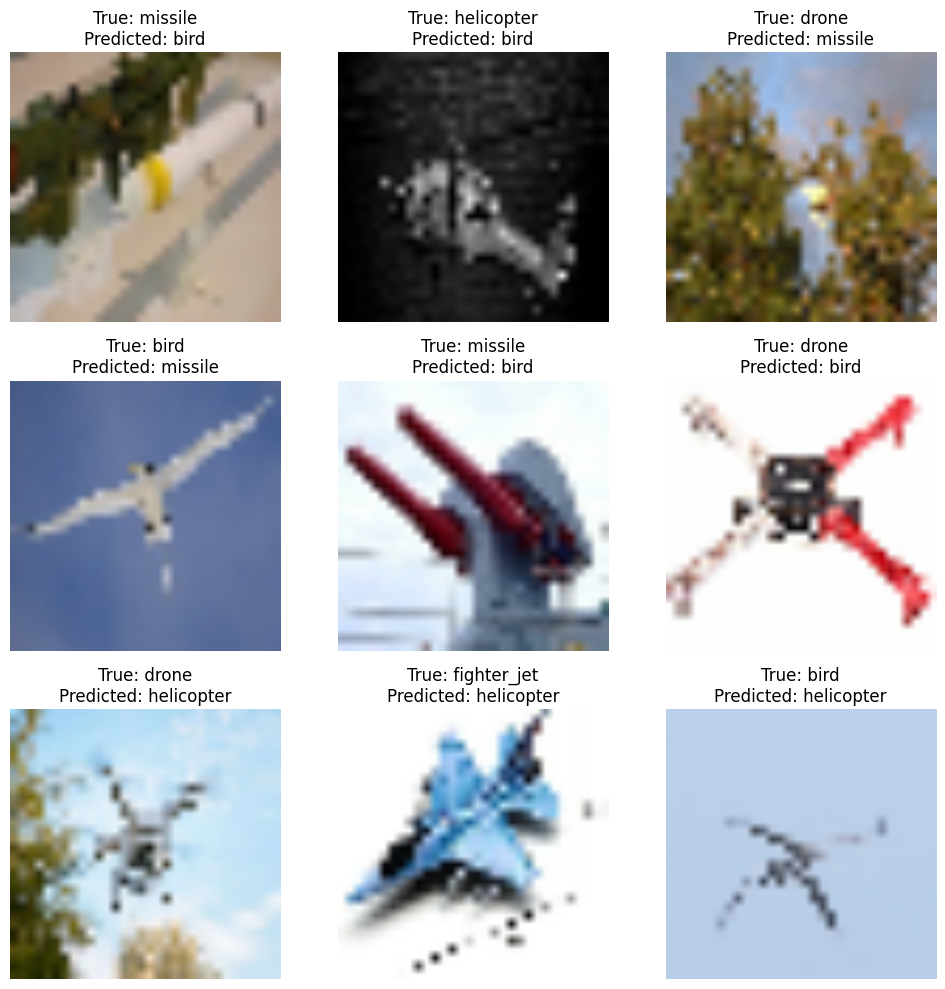

In [ ]:
misclassified_samples_BP = collect_misclassified_samples(BP_model, val_ds, num_samples=9)
display_misclassified_samples(misclassified_samples_BP)

# Alternative Model Training

In [ ]:

AM_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
AM_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


AM_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30
)

Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 52s 226ms/step - accuracy: 0.3611 - loss: 1.4479 - val_accuracy: 0.4972 - val_loss: 1.1982
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 36s 164ms/step - accuracy: 0.5188 - loss: 1.1800 - val_accuracy: 0.5940 - val_loss: 1.0177
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - accuracy: 0.5986 - loss: 1.0251 - val_accuracy: 0.6355 - val_loss: 0.9436
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.6253 - loss: 0.9672 - val_accuracy: 0.6481 - val_loss: 0.9166
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 37s 168ms/step - accuracy: 0.6666 - loss: 0.8877 - val_accuracy: 0.6902 - val_loss: 0.8344
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 43s 175ms/step - accuracy: 0.6756 - loss: 0.8437 - val_accuracy: 0.6942 - val_loss: 0.8195
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.7097 - loss: 0.7878 - val_accuracy: 0.6765 - val_loss: 0.8791
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 37s 154ms/step - accuracy: 0.7205 - loss: 0

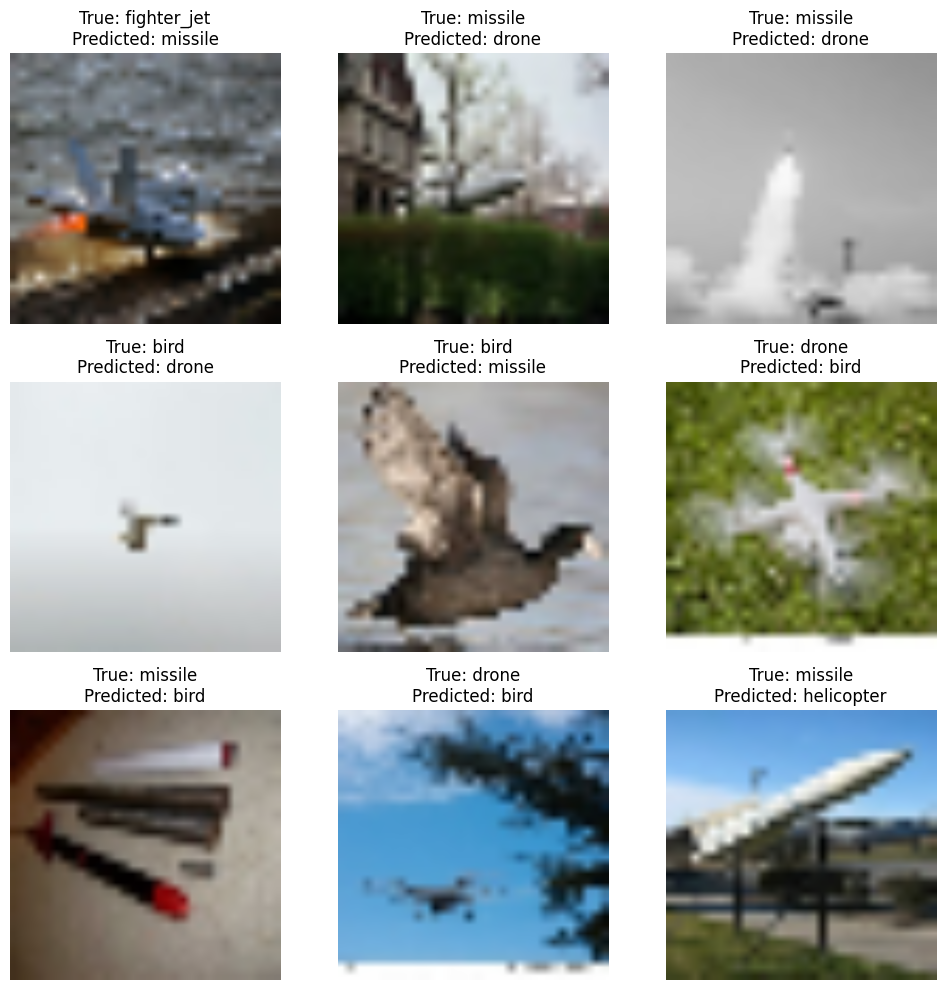

In [ ]:
misclassified_samples_AM = collect_misclassified_samples(AM_model, val_ds, num_samples=9)
display_misclassified_samples(misclassified_samples_AM)